In [439]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [440]:
import pickle
import os, sys
import copy
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colorbar, colors, gridspec
from metpy import plots as metpy_plots
from matplotlib.colors import ListedColormap, BoundaryNorm


HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))


from dsrnngan.plots import plot_precip, plot_contourf
from dsrnngan.data import denormalise, DEFAULT_LATITUDE_RANGE, DEFAULT_LONGITUDE_RANGE
from dsrnngan import data
from dsrnngan.noise import NoiseGenerator
from dsrnngan.rapsd import plot_spectrum1d, rapsd
from dsrnngan.thresholded_ranks import findthresh

In [441]:
# eval_df = pd.read_csv(os.path.join(log_folder, 'eval_validation.csv'))
# eval_df.head()

In [442]:
model_number = 160000
# model_number = 115200
model_type = 'basic'

log_folders = {'basic': '/user/work/uz22147/logs/cgan/d9b8e8059631e76f/n1000_201806-201905_e50',
               'full_image': '/user/work/uz22147/logs/cgan/43ae7be47e9a182e_full_image/n1000_201806-201905_e50',
               'cropped': '/user/work/uz22147/logs/cgan/43ae7be47e9a182e/n1000_201806-201905_e50'}

log_folder = log_folders[model_type]
with open(os.path.join(log_folder, f'arrays-{model_number}.pkl'), 'rb') as ifh:
    arrays = pickle.load(ifh)
    
truth_array = arrays['truth']
samples_gen_array = arrays['samples_gen']
fcst_array = arrays['fcst_array']
ensmean_array = np.mean(arrays['samples_gen'], axis=-1)
dates = [d[0] for d in arrays['dates']]
hours = [h[0] for h in arrays['hours']]

assert len(set(list(zip(dates, hours)))) == fcst_array.shape[0], "Degenerate date/hour combinations"
(n_samples, width, height, ensemble_size) = samples_gen_array.shape


In [443]:
from dsrnngan.utils import load_yaml_file
# Get lat/lon range from log folder
base_folder = '/'.join(log_folder.split('/')[:-1])
config = load_yaml_file(os.path.join(base_folder, 'setup_params.yaml'))

min_latitude = config['DATA']['min_latitude']
max_latitude = config['DATA']['max_latitude']
latitude_step_size = config['DATA']['latitude_step_size']
min_longitude = config['DATA']['min_longitude']
max_longitude = config['DATA']['max_longitude']
longitude_step_size = config['DATA']['longitude_step_size']
latitude_range=np.arange(min_latitude, max_latitude, latitude_step_size)
longitude_range=np.arange(min_longitude, max_longitude, longitude_step_size)

lat_range_list = [np.round(item, 2) for item in sorted(latitude_range)]
lon_range_list = [np.round(item, 2) for item in sorted(longitude_range)]

special_areas = {'lake_victoria': {'lat_range': [-3.05,1.05], 'lon_range': [31.05, 35.05]},
                 'nairobi': {'lat_range': [-1.55,-1.05], 'lon_range': [36.55, 37.05]},
                 'mombasa (coastal)': {'lat_range': [-4.15,-3.95], 'lon_range': [39.55, 39.85]},
                #  'addis ababa': {'lat_range': [8.8, 9.1], 'lon_range': [38.5, 38.9]},
                 'bale_mountains': {'lat_range': [6.65, 7.05], 'lon_range': [39.35, 40.25]},
                #  'Butembo / virunga (DRC)': {'lat_range': [-15.05, 0.55], 'lon_range': [29.05, 29.85]},
                 'Kampala': {'lat_range': [.05, 0.65], 'lon_range': [32.15, 32.95]},
                 'Nzoia basin': {'lat_range': [-0.35, 1.55], 'lon_range': [34.55, 36.55]}}

for k, v in special_areas.items():
    special_areas[k]['lat_index_range'] = [lat_range_list.index(v['lat_range'][0]), lat_range_list.index(v['lat_range'][1])]
    special_areas[k]['lon_index_range'] = [lon_range_list.index(v['lon_range'][0]), lon_range_list.index(v['lon_range'][1])]


## Quantile mapping (basic)

In [444]:
import xarray as xr

all_imerg_data = []
all_ifs_data = []
ifs_dates = []
imerg_dates = []

for year in tqdm([2016, 2017]):
    for month in range(1,13):

        imerg_ds = xr.open_dataarray(f'/user/home/uz22147/repos/rainfall_data/daily_imerg_rainfall_{month}_{year}.nc')

        imerg_data = imerg_ds.sel(lat=latitude_range, method='nearest').sel(lon=longitude_range, method='nearest').values
        
        imerg_dates += [d.astype('M8[D]').astype('O') for d in imerg_ds.time.values]

        for t in range(imerg_data.shape[0]):
            
            snapshot = imerg_data[t, :, :]
            
            all_imerg_data.append(snapshot)
        
        try:
            ifs_ds = xr.open_dataarray(f'/user/home/uz22147/repos/rainfall_data/daily_ifs_rainfall_{month}_{year}.nc')

            ifs_data = ifs_ds.sel(lat=latitude_range, method='nearest').sel(lon=longitude_range, method='nearest').values

            for t in range(ifs_data.shape[0]):
                
                snapshot = ifs_data[t, :, :]
                
                all_ifs_data.append(snapshot)
            ifs_dates += [d.astype('M8[D]').astype('O') for d in ifs_ds.time.values]

        except:
            pass

all_imerg_data = np.stack(all_imerg_data, axis = 0)
all_ifs_data = np.stack(all_ifs_data, axis = 0)

100%|██████████| 2/2 [00:05<00:00,  2.67s/it]


In [446]:
from itertools import chain

overlapping_dates = sorted(set(ifs_dates).intersection(imerg_dates))

assert len(overlapping_dates) == len(ifs_dates), "This code can't cope with different date ranges yet!"
month_ranges = [[1,2], [3,4,5], [6,7,8,9], [10,11,12]]
# month_ranges = [[1,2, 6,7,8,9], [3,4,5, 10,11,12]]
# month_ranges = [list(range(1,13))]

date_chunks =  {'_'.join([str(month_range[0]), str(month_range[-1])]): [item for item in overlapping_dates if item.month in month_range] for month_range in month_ranges}
date_indexes = {k : [overlapping_dates.index(item) for item in chunk] for k, chunk in date_chunks.items()}

assert len(list(chain.from_iterable(date_chunks.values()))) == len(overlapping_dates)

num_lat_lon_chunks =2
lat_chunk_size = int(len(lat_range_list)/num_lat_lon_chunks)
lat_range_chunks = [lat_range_list[n*lat_chunk_size:(n+1)*lat_chunk_size] for n in range(num_lat_lon_chunks)]
lat_range_chunks[-1] = lat_range_chunks[-1] + lat_range_list[num_lat_lon_chunks*lat_chunk_size:]

lon_chunk_size = int(len(lon_range_list)/num_lat_lon_chunks)
lon_range_chunks = [lon_range_list[n*lon_chunk_size:(n+1)*lon_chunk_size] for n in range(num_lat_lon_chunks)]
lon_range_chunks[-1] = lon_range_chunks[-1] + lon_range_list[num_lat_lon_chunks*lon_chunk_size:]

print(f'lat chunk size: {lat_chunk_size}, lon chunk size: {lon_chunk_size},')


quantile_areas = {}
for t_name, d in date_indexes.items():
    for n, lat_chunk in enumerate(lat_range_chunks):
        for m, lon_chunk in enumerate(lon_range_chunks):
            
            lat_rng = [lat_chunk[0], lat_chunk[-1]]
            lon_rng = [lon_chunk[0], lon_chunk[-1]]
            
            lat_index_range = [lat_range_list.index(lat_rng[0]), lat_range_list.index(lat_rng[1])]
            lon_index_range = [lon_range_list.index(lon_rng[0]), lon_range_list.index(lon_rng[1])]
            
            quantile_areas[f't{t_name}_lat{n}_lon{m}'] = {'lat_range': lat_rng, 'lon_range': lon_rng,
                                                     'lat_index_range': lat_index_range,
                                                     'lon_index_range': lon_index_range,
                                                     'date_indexes': d}


lat chunk size: 100, lon chunk size: 100,


In [447]:
from scipy.ndimage import uniform_filter

step_size = 0.001
range_dict = {0: {'start': 0.1, 'stop': 1, 'interval': 0.1, 'marker': '+', 'marker_size': 32},
              1: {'start': 1, 'stop': 10, 'interval': 1, 'marker': '+', 'marker_size': 256},
              2: {'start': 10, 'stop': 91, 'interval':10, 'marker': '+', 'marker_size': 512},
              3: {'start': 95, 'stop': 99.1, 'interval': 1, 'marker': '+', 'marker_size': 256},
              4: {'start': 99.1, 'stop': 99.91, 'interval': 0.1, 'marker': '+', 'marker_size': 128},
              5: {'start': 99.9, 'stop': 99.99, 'interval': 0.01, 'marker': '+', 'marker_size': 32 },
              6: {'start': 99.99, 'stop': 99.999, 'interval': 0.001, 'marker': '+', 'marker_size': 10}}
                  
percentiles_list= [np.arange(item['start'], item['stop'], item['interval']) for item in range_dict.values()]
percentiles=np.concatenate(percentiles_list)
quantile_boundaries = [item / 100 for item in percentiles]

print(f'Minimum number of points per quantile = {0.001*all_imerg_data.size}')

Minimum number of points per quantile = 29386.2


In [448]:
from dsrnngan.benchmarks import get_quantiles_by_area, get_quantile_mapped_forecast

In [ ]:
quantiles_by_area = get_quantiles_by_area(quantile_areas, fcst_data=all_ifs_data, obs_data=all_imerg_data, quantile_boundaries=quantile_boundaries)
fcst_corrected = get_quantile_mapped_forecast(fcst_array, dates, hours, month_ranges, quantile_areas, quantiles_by_area)

## Long term IMERG observations


In [ ]:
all_imerg_data = []
all_ifs_data = []

for year in tqdm(range(2003, 2018)):
    for month in range(1,13):

        imerg_ds = xr.open_dataarray(f'/user/home/uz22147/repos/rainfall_data/daily_imerg_rainfall_{month}_{year}.nc')

        imerg_data = imerg_ds.sel(lat=latitude_range, method='nearest').sel(lon=longitude_range, method='nearest').values

        for t in range(imerg_data.shape[0]):
            
            snapshot = imerg_data[t, :, :]
            
            all_imerg_data.append(snapshot)
            
all_imerg_data = np.stack(all_imerg_data, axis = 0)

daily_historical_avg = np.mean(all_imerg_data, axis=0)
daily_historical_std = np.std(all_imerg_data, axis=0)

hourly_historical_avg = daily_historical_avg / 24
hourly_historical_std = daily_historical_std / 24

 40%|████      | 6/15 [00:05<00:08,  1.01it/s]


KeyboardInterrupt: 

In [ ]:
# Summary statistics
array_dict = {'IFS': fcst_array, 'IFS qmap': fcst_corrected ,'iMERG': truth_array, 'cGAN': samples_gen_array}
for k, v in array_dict.items():
    
    print('*'*10)
    print(k)
    print('Mean = ', v.mean())
    print('Max = ', v.max())
    print('Min = ', v.min())

**********
IFS
Mean =  0.09099386307781572
Max =  56.8789690732956
Min =  0.0
**********
IFS qmap
Mean =  0.07665105090452926
Max =  156.87730354920538
Min =  0.0
**********
iMERG
Mean =  0.106215574
Max =  103.5872
Min =  0.0
**********
cGAN
Mean =  0.12139652
Max =  42364.54
Min =  0.0


In [ ]:
# Find dry and rainy days in sampled dataset
means = [(n, truth_array[n,:,:].mean()) for n in range(n_samples)]
sorted_means = sorted(means, key=lambda x: x[1])

n_extreme_days = 10
wet_day_indexes = [item[0] for item in sorted_means[-10:]]
dry_day_indexes = [item[0] for item in sorted_means[:10]]

In [ ]:
def clip_outliers(data, lower_pc=2.5, upper_pc=97.5):
    
    data_clipped = copy.deepcopy(data)
    data_clipped[data_clipped<np.percentile(data_clipped, lower_pc)] = np.percentile(data_clipped, lower_pc)  #using percentiles rather than indexing a sorted list of the array values allows this to work even when data is a small array. (I've not checked if this works for masked data.)
    data_clipped[data_clipped>np.percentile(data_clipped, upper_pc)] = np.percentile(data_clipped, upper_pc)

    return data_clipped


100%|██████████| 4/4 [00:00<00:00,  8.33it/s]


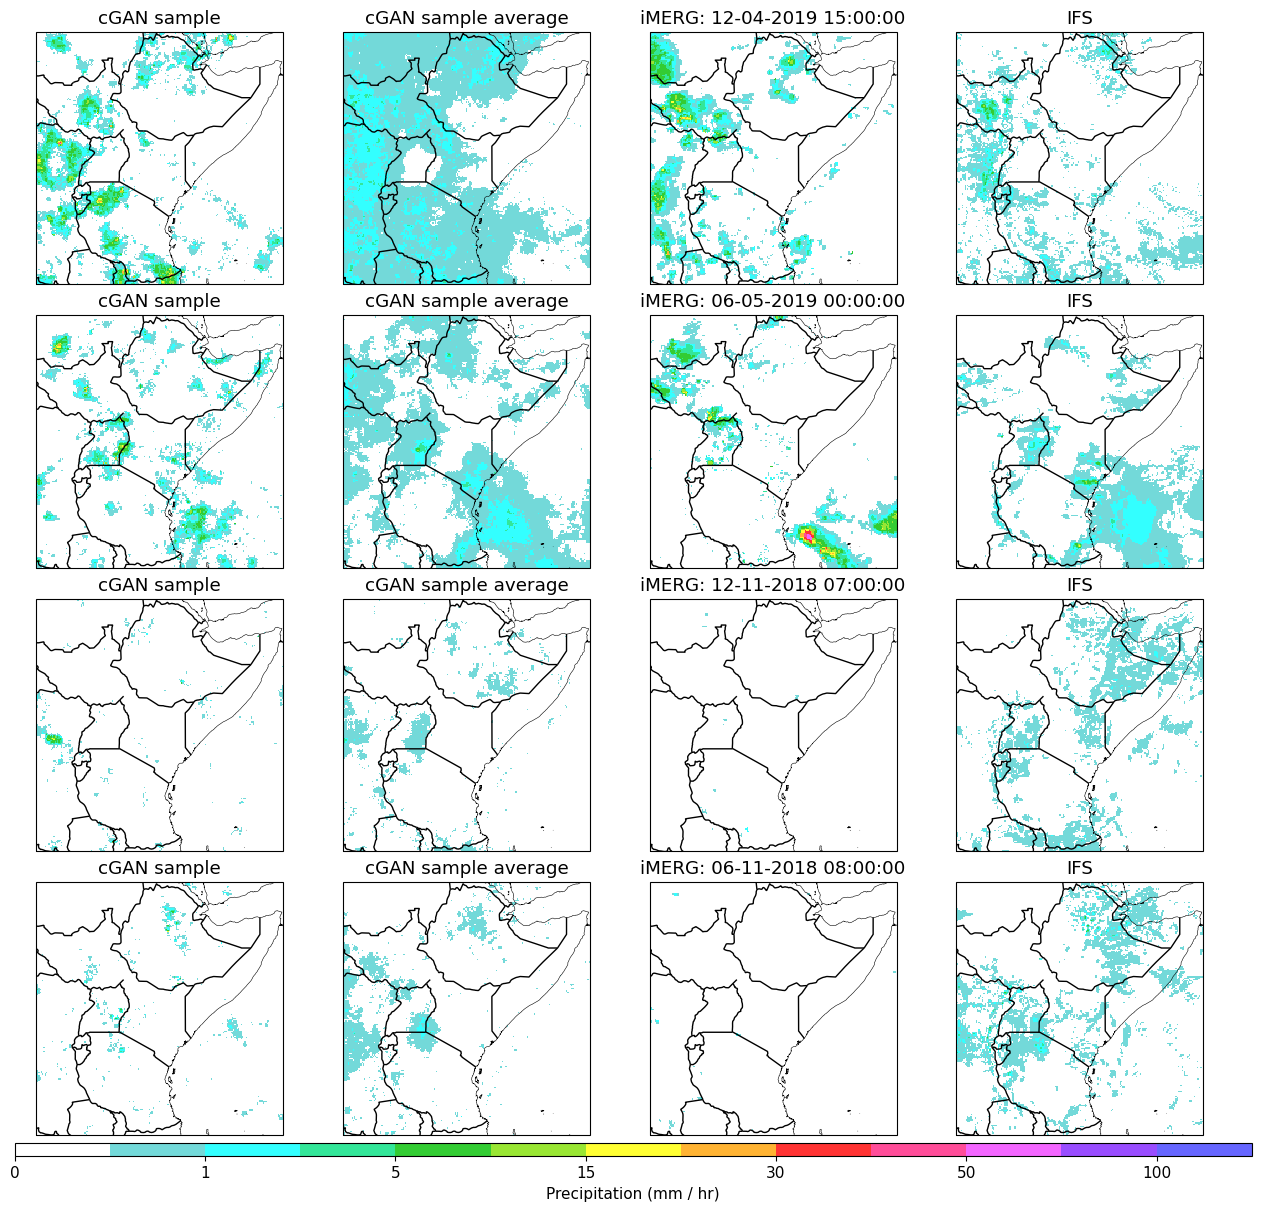

In [ ]:
from dsrnngan.data import DEFAULT_LATITUDE_RANGE, DEFAULT_LONGITUDE_RANGE
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

tp_index = data.all_ifs_fields.index('tp')

# plot configurations
levels = [0, 0.1, 1, 2.5, 5, 10, 15, 20, 30, 40, 50, 70, 100, 150] # in units of log10
precip_cmap = ListedColormap(metpy_plots.ctables.colortables["precipitation"][:len(levels)-1], 'precipitation')
precip_norm = BoundaryNorm(levels, precip_cmap.N)
plt.rcParams.update({'font.size': 11})
spacing = 10
units = "Rain rate [mm h$^{-1}$]"
precip_levels=np.arange(0, 1.5, 0.15)

indexes = wet_day_indexes[:2] + dry_day_indexes[:2]
num_cols = 5
num_samples = len(indexes)
num_rows = num_samples
# , figsize = (num_rows*4, num_cols*4)),
# gs = gridspec.GridSpec(spacing*num_rows+1, spacing*num_cols, wspace=0.5, hspace=2)
rows = [[f'cgan_sample_{n}', f'cgan_mean_{n}', f'imerg_{n}', f'ifs_{n}', 'cbar'] for n in range(num_rows)]

fig = plt.figure(constrained_layout=True, figsize=(2.5*num_cols, 3*num_rows))
gs = gridspec.GridSpec(num_rows + 1, num_cols, figure=fig, 
                       width_ratios=[1]*(num_cols - 1) + [0.05],
                       height_ratios=[1]*(num_rows) + [0.05],
                       wspace=0.005)                      
for n in tqdm(range(len(indexes))):

    ix = indexes[n]
    img_gens = samples_gen_array[ix, :,:,:]
    truth = truth_array[ix,:,:]
    fcst = fcst_array[ix,:,:]
    date = dates[ix]
    hour = hours[ix]
    avg_img_gens = img_gens.mean(axis=-1)
    date_str = date[0].strftime('%d-%m-%Y') + f' {hour[0]:02d}:00:00'
    
    # cGAN
    data_lookup = {'cgan_sample': {'data': img_gens[:,:,0], 'title': 'cGAN sample'},
                   'cgan_mean': {'data': avg_img_gens, 'title': f'cGAN sample average'},
                   'imerg' : {'title': f"iMERG: {date_str}", 'data': truth},
                   'ifs': {'data': fcst, 'title': 'IFS'}
                   }
    for col, (k, val) in enumerate(data_lookup.items()):
   
        ax = fig.add_subplot(gs[n, col], projection = ccrs.PlateCarree())
        # im = plot_precip(np_array=np.log(val['data']), ax=ax)
        ax.coastlines(resolution='10m', color='black', linewidth=0.4)
        
        clipped_data = clip_outliers(val['data'], lower_pc=0.1, upper_pc=99.9)
        im = ax.imshow(val['data'],
                interpolation='nearest',
                norm=precip_norm,
                cmap=precip_cmap,
                origin='lower',
                extent=[min(DEFAULT_LONGITUDE_RANGE), max(DEFAULT_LONGITUDE_RANGE), 
                  min(DEFAULT_LATITUDE_RANGE), max(DEFAULT_LATITUDE_RANGE)],
                transform=ccrs.PlateCarree(),
                alpha=0.8)
        ax.add_feature(cfeature.BORDERS)
        ax.set_title(val['title'])
        
# precip_cmap = ListedColormap(metpy_plots.ctables.colortables["precipitation"][:len(precip_levels)-1], 'precipitation')
# precip_norm = BoundaryNorm(precip_levels, precip_cmap.N)
cbar_ax = fig.add_subplot(gs[-1, :])
# cb = mpl.colorbar.Colorbar(axd['cbar'], cmap=precip_cmap, norm=precip_norm)
# cbar_ax = fig.add_axes([0.95, 0.0, 0.02, 0.95])
cb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink = 0.2, aspect=10,
                  )

# cb.ax.set_yticks(precip_levels)
# cb.ax.set_yticklabels(precip_levels)
# cb.ax.tick_params(axis='both', which='major')
cb.ax.set_xlabel("Precipitation (mm / hr)", loc='center')


plt.savefig(f'cGAN_samples_IFS_{model_type}_{model_number}.png', format='png')

## Rank histogram

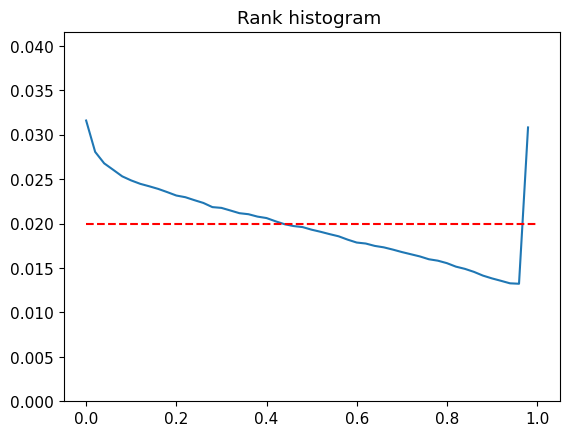

In [ ]:
rng = np.random.default_rng()
noise_factor = 1e-6
n_samples = 100

temp_truth = np.repeat(truth_array[:n_samples, :, : ,None].copy(), samples_gen_array.shape[-1], axis=-1)
temp_samples = samples_gen_array[:n_samples, :, :, :].copy()

temp_truth += rng.random(size=temp_truth.shape, dtype=np.float32)*noise_factor
temp_samples += rng.random(size=temp_samples.shape, dtype=np.float32)*noise_factor

ranks = np.sum(temp_truth > temp_samples, axis=-1)

fig, ax = plt.subplots(1,1)
(h, _) = np.histogram(ranks.flatten(), bins=50)
h = h / h.sum()
ax.plot(h)
ax.hlines(1/50, 0, 50, linestyles='dashed', colors=['r'])
ax.set_xticks(np.arange(0, 51, 10))
ax.set_xticklabels(np.round(np.arange(0, 1.2, 0.2), 1))
ax.set_ylim([0, max(h)+0.01])
ax.set_title('Rank histogram ')
plt.savefig(f'cgan_metrics/rank_hist_{model_number}.png')

# RAPSD

In [ ]:
from dsrnngan.rapsd import rapsd

rapsd_truth = []
rapsd_pred = []
rapsd_fcst = []
rapsd_fcst_corrected = []  

for n in tqdm(range(n_samples)):
        fft_freq_pred = rapsd(truth_array[n,:,:], fft_method=np.fft)
        rapsd_truth.append(fft_freq_pred)
        
        fft_freq_pred = rapsd(samples_gen_array[n,:,:,0], fft_method=np.fft)
        rapsd_pred.append(fft_freq_pred)

        fft_freq_fcst = rapsd(fcst_array[n, :, :], fft_method=np.fft)
        rapsd_fcst.append(fft_freq_fcst)
        
        fft_freq_fcst_corrected = rapsd(fcst_corrected[n, :, :], fft_method=np.fft)
        rapsd_fcst_corrected.append(fft_freq_fcst_corrected)

rapsd_truth = np.mean(np.stack(rapsd_truth, axis=-1), axis=-1)
rapsd_pred = np.mean(np.stack(rapsd_pred, axis=-1), axis=-1)
rapsd_fcst = np.mean(np.stack(rapsd_fcst, axis=-1), axis=-1)
rapsd_fcst_corrected = np.mean(np.stack(rapsd_fcst_corrected, axis=-1), axis=-1)

100%|██████████| 1000/1000 [00:26<00:00, 37.86it/s]


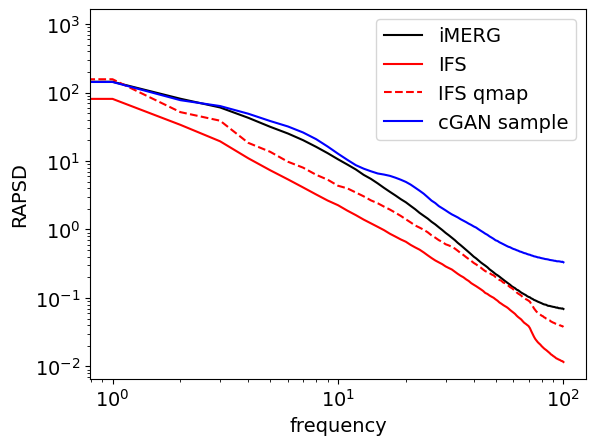

In [ ]:
fig, ax = plt.subplots(1,1)

ax.plot(rapsd_truth, label='iMERG', color='k')
ax.plot(rapsd_fcst, 'r', label='IFS')
ax.plot(rapsd_fcst_corrected, 'r--', label='IFS qmap')
ax.plot(rapsd_pred, 'b', label='cGAN sample') # Single member of ensemble
plt.xscale('log')
plt.yscale('log')
ax.set_ylabel('RAPSD')
ax.set_xlabel('frequency')
ax.legend()
plt.rcParams.update({'font.size': 14})
plt.savefig(f'cgan_metrics/rapds_{model_type}_{model_number}.png', format='png')

## Quantiles

In [ ]:
#List of percentiles to plot in the middle of the distribution (more extreme percentiles are derived from the data)
#The percentiles in each element of the list are plotted with different symbols
#every tenth between 10th to 90th and every 1 between 1st-5th and 95th-99th (similar to Guillod et al., 2016, fig.11).

range_dict = {0: {'start': 0.1, 'stop': 1, 'interval': 0.1, 'marker': '+', 'marker_size': 32},
              1: {'start': 1, 'stop': 10, 'interval': 1, 'marker': '+', 'marker_size': 256},
              2: {'start': 10, 'stop': 91, 'interval':10, 'marker': '+', 'marker_size': 512},
              3: {'start': 95, 'stop': 99.1, 'interval': 1, 'marker': '+', 'marker_size': 256},
              4: {'start': 99.1, 'stop': 99.91, 'interval': 0.1, 'marker': '+', 'marker_size': 128},
              5: {'start': 99.9, 'stop': 99.99, 'interval': 0.01, 'marker': '+', 'marker_size': 32 },
              6: {'start': 99.99, 'stop': 99.999, 'interval': 0.001, 'marker': '+', 'marker_size': 10}}
                  
percentiles_list= [np.arange(item['start'], item['stop'], item['interval']) for item in range_dict.values()]
percentiles=np.concatenate(percentiles_list)
quantile_boundaries = [item / 100 for item in percentiles]

In [ ]:
# Quantiles for annotating plot

(q_99pt9, q_99pt99) = np.quantile(truth_array, [0.999, 0.9999])

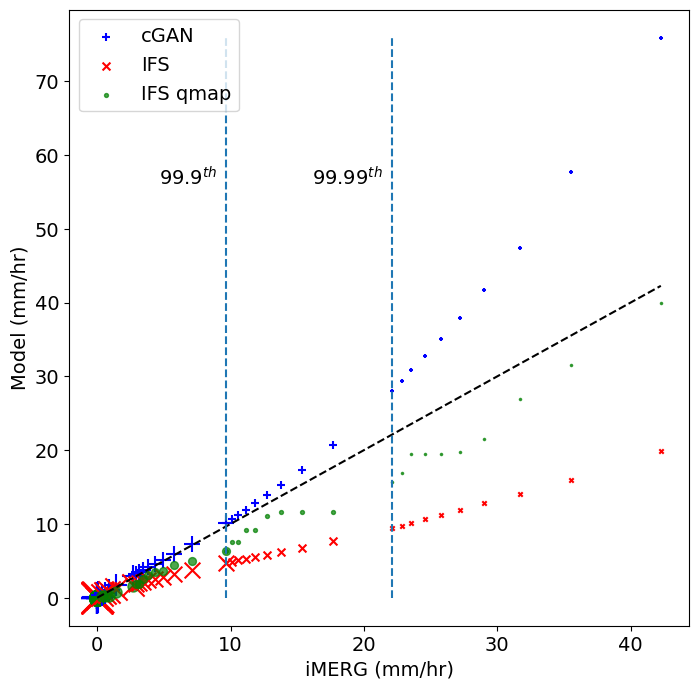

In [452]:
import itertools


fig, ax = plt.subplots(1,1, figsize=(8,8))

marker_handles = None
for v in range_dict.values():
    
    quantile_boundaries = np.arange(v['start'], v['stop'], v['interval']) / 100
    
    truth_quantiles = np.quantile(truth_array, quantile_boundaries)
    sample_quantiles = np.quantile(samples_gen_array[:,:,:,0], quantile_boundaries)
    fcst_quantiles = np.quantile(fcst_array, quantile_boundaries)
    fcst_corrected_quantiles = np.quantile(fcst_corrected, quantile_boundaries)

    max_fcst_val = max(max(sample_quantiles), max(fcst_quantiles))
    max_truth_val = max(truth_quantiles)
    
    size=v['marker_size']
    cmap = plt.colormaps["plasma"]
    marker = v['marker']

    s1 = ax.scatter(truth_quantiles, sample_quantiles, c='blue', marker='+', label='cGAN', s=size, cmap=cmap)
    s2 = ax.scatter(truth_quantiles, fcst_quantiles, c='red', marker='x', label='IFS', s=size, cmap=cmap)
    s3 = ax.scatter(truth_quantiles, fcst_corrected_quantiles, c='green', marker='.', label='IFS qmap', s=size, cmap=cmap, alpha=0.7)

    
    if not marker_handles:
        marker_handles = [s1, s2, s3]

# all_marker_handles = list(itertools.chain.from_iterable(marker_handles.values()))
ax.legend(handles=marker_handles, loc='upper left')
ax.plot(np.linspace(0, max_truth_val, 100), np.linspace(0, max_truth_val, 100), 'k--')
ax.set_xlabel('iMERG (mm/hr)')
ax.set_ylabel('Model (mm/hr)')


ax.vlines(q_99pt9, 0, max(sample_quantiles), linestyles='--')
ax.vlines(q_99pt99, 0, max(sample_quantiles), linestyles='--')
ax.text(q_99pt9 - 5, max(sample_quantiles) - 20, '$99.9^{th}$')
ax.text(q_99pt99 -6 , max(sample_quantiles) - 20, '$99.99^{th}$')

plt.rcParams.update({'font.size': 14})
# plt.savefig(f'cgan_metrics/quantiles_total_{model_number}.pdf', format='pdf')

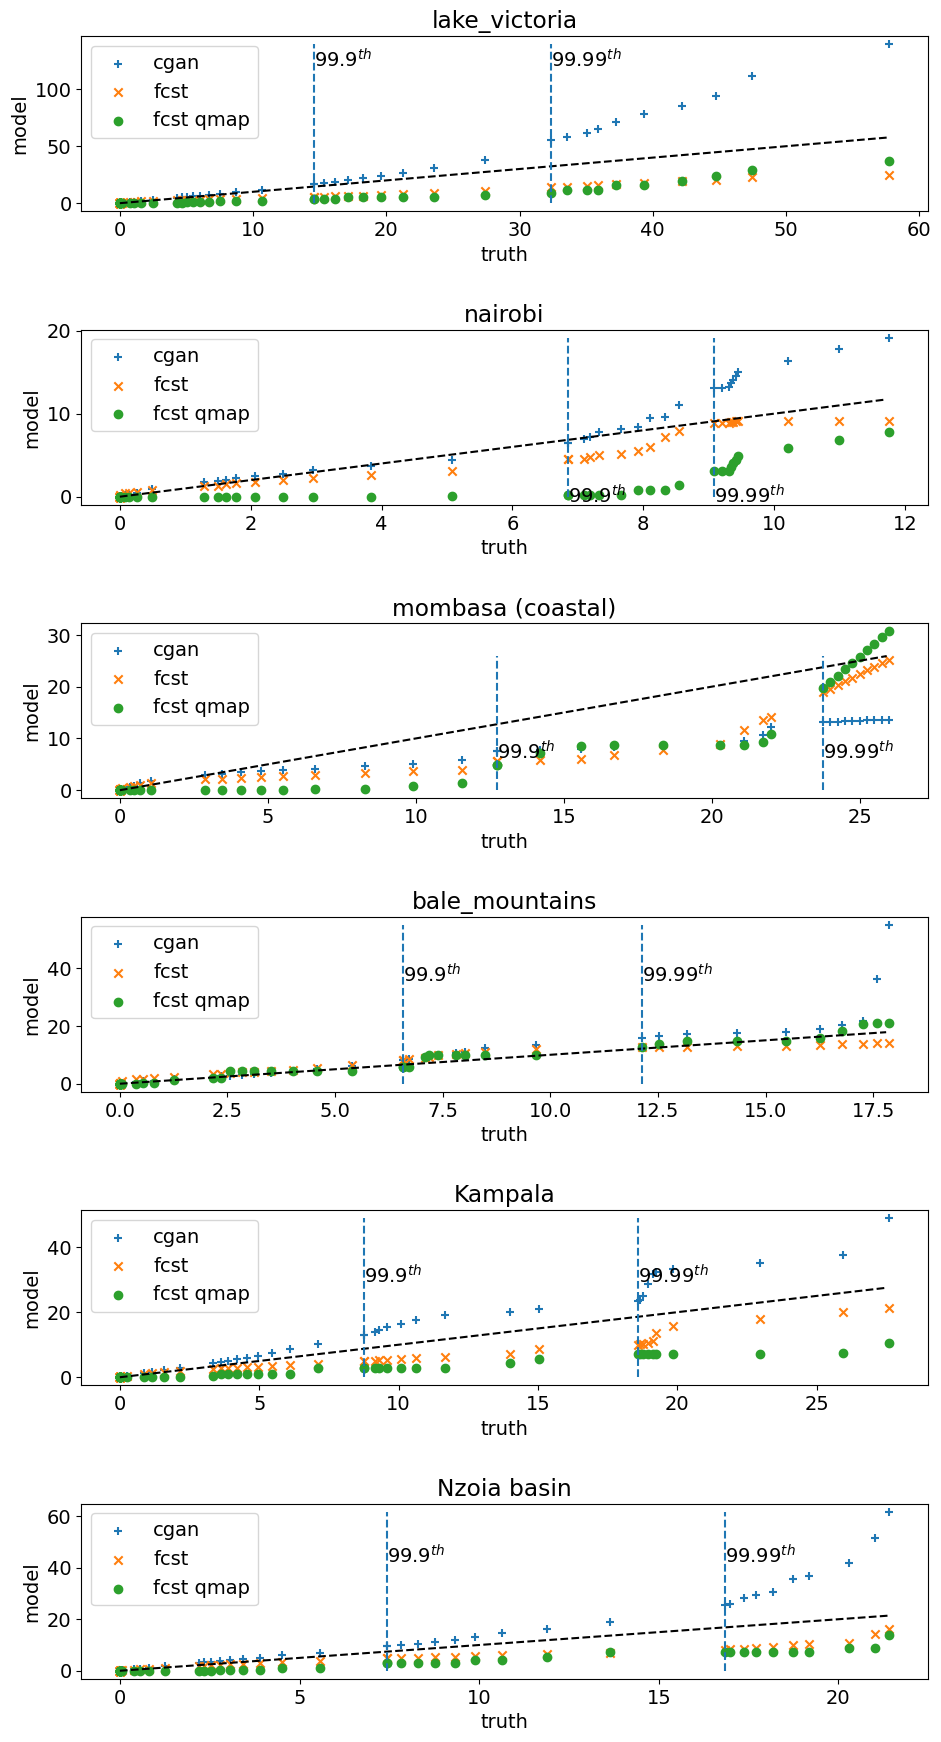

In [ ]:
# Quantiles for different areas

percentiles_list= [np.arange(item['start'], item['stop'], item['interval']) for item in range_dict.values()]
percentiles=np.concatenate(percentiles_list)
quantile_boundaries = [item / 100 for item in percentiles]

fig, ax = plt.subplots(max(2, len(special_areas)),1, figsize=(10, 18))
fig.tight_layout(pad=4)
for n, (area, area_range) in enumerate(special_areas.items()):


    lat_range = area_range['lat_index_range']
    lon_range = area_range['lon_index_range']
    truth_quantiles = np.quantile(truth_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], quantile_boundaries)
    sample_quantiles = np.quantile(samples_gen_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1], 0], quantile_boundaries)
    fcst_quantiles = np.quantile(fcst_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], quantile_boundaries)
    fcst_corrected_quantiles = np.quantile(fcst_corrected[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], quantile_boundaries)
    
    max_val = max(truth_quantiles)
    
    ax[n].scatter(truth_quantiles, sample_quantiles, marker='+', label='cgan')
    ax[n].scatter(truth_quantiles, fcst_quantiles, marker='x', label='fcst')
    ax[n].scatter(truth_quantiles, fcst_corrected_quantiles, marker='o', label='fcst qmap')
    ax[n].plot(np.arange(0,max_val, 0.1), np.arange(0,max_val, 0.1), 'k--')
    ax[n].set_xlabel('truth')
    ax[n].set_ylabel('model')
    ax[n].set_title(area)
    # ax[n].set_xlim([-0.01, max_val + 0.01])
    # ax[n].set_ylim([-0.01, max_val + 0.01])
    ax[n].legend(loc='upper left')
    
    max_line_val = max(max(sample_quantiles), max_val, max(fcst_quantiles))
    (q_99pt9, q_99pt99) = np.quantile(truth_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], [0.999, 0.9999])
    ax[n].vlines(q_99pt9, 0, max_line_val, linestyles='--')
    ax[n].vlines(q_99pt99, 0, max_line_val, linestyles='--')
    ax[n].text(q_99pt9 , max_line_val - 20, '$99.9^{th}$')
    ax[n].text(q_99pt99 , max_line_val - 20, '$99.99^{th}$')
    
fig.tight_layout(pad=2.0)
plt.savefig('cgan_metrics/quantiles_area.png')

## Histograms

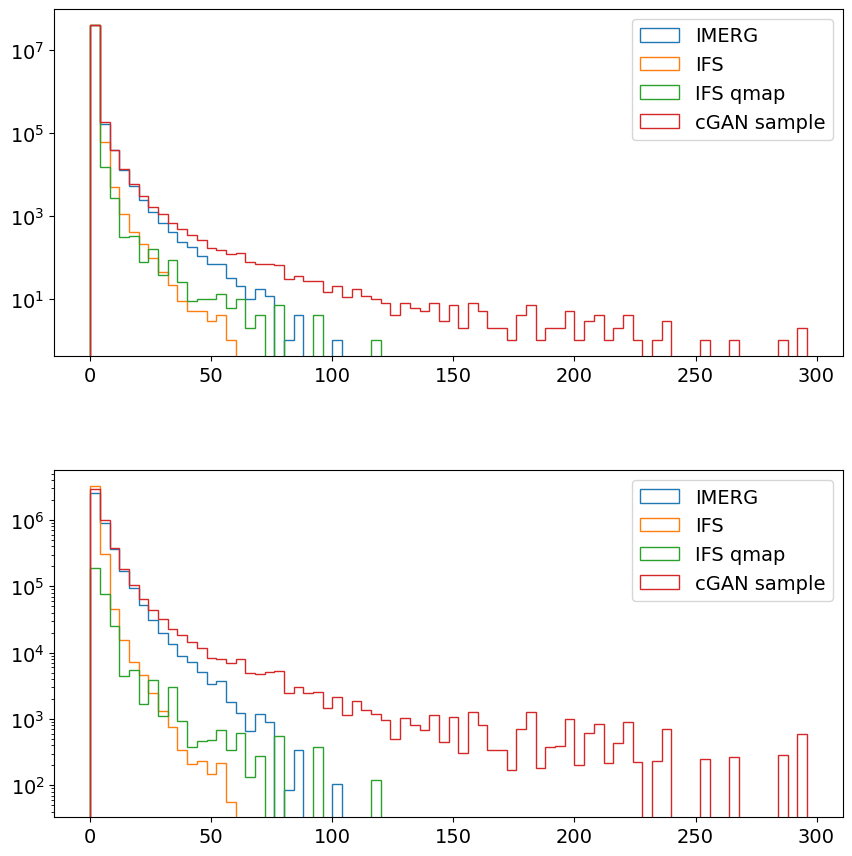

In [ ]:
from itertools import chain

# quantile histograms

fig, axs = plt.subplots(2,1, figsize=(10,10))
fig.tight_layout(pad=4)
bin_boundaries=np.arange(0,300,4)

data_dict = {'IMERG': truth_array, 'IFS': fcst_array, 'IFS qmap': fcst_corrected, 'cGAN sample': samples_gen_array[:,:,:,0]}
rainfall_amounts = {}

edge_colours = ["b", "g", "o"]
for n, (name, arr) in enumerate(data_dict.items()):
    (bin_count, bin_values) = np.histogram(arr.flatten(), bins=bin_boundaries)

    axs[0].hist(arr.flatten(), bins=bin_boundaries, histtype='step', label=name)
    
    bin_centres = [0.5*(bin_values[n] + bin_values[n+1]) for n in range(len(bin_values) -1)]
    # rainfall_amounts[name] = [bin_count[n] * bin_centres[n] for n in range(len(bin_centres))]
    # axs[1].bar(np.array(bin_centres), rainfall_amounts[name], width=4, label=name, alpha=0.5, color='w', linewidth=1, edgecolor='k')
    axs[1].hist(arr.flatten(), bins=bin_boundaries, histtype='step', label=name, weights=arr.flatten())

      
for ax in axs:
    ax.set_yscale('log')
    ax.legend()
    # ax.set_xlabel('Average hourly rainfall in bin (mm/hr)')
    # ax.set_ylabel('Total amount of rainfall in bin (mm/hr)')
# plt.savefig(f'cgan_metrics/histograms_{model_number}.png', format='png')


## Long term average and std for IMERG, plus quantile mapping


## Bias and RMSE

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colorbar, colors, gridspec


In [ ]:
# RMSE
rmse_dict = {'single_sample_rmse': np.sqrt(np.mean(np.square(truth_array - samples_gen_array[:,:,:,0]), axis=0)),
            'ensmean_rmse' : np.sqrt(np.mean(np.square(truth_array - np.mean(samples_gen_array, axis=-1)), axis=0)),
            'fcst_rmse' : np.sqrt(np.mean(np.square(truth_array - fcst_array), axis=0))}

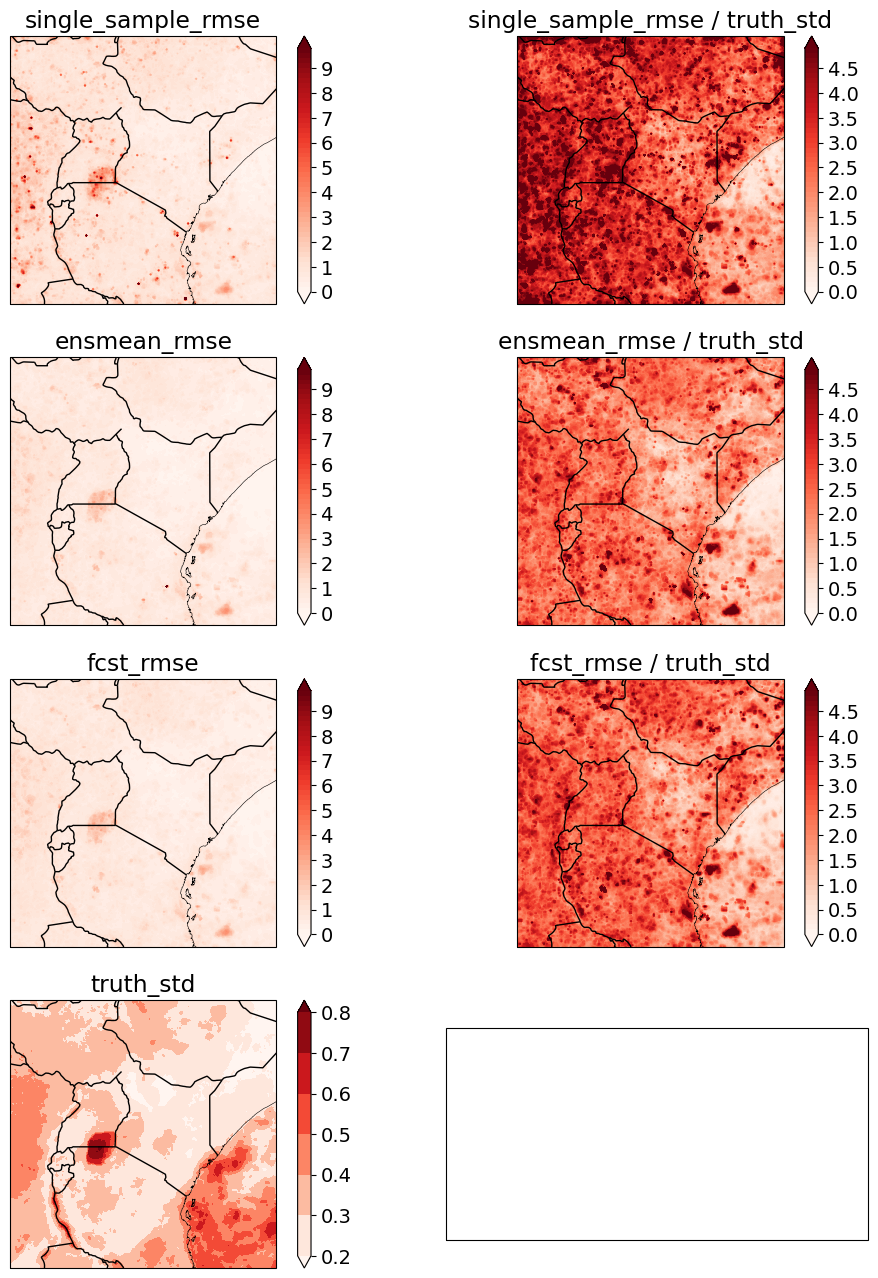

In [ ]:
# RMSE
fig, ax = plt.subplots(len(rmse_dict.keys())+1,2, 
                       subplot_kw={'projection' : ccrs.PlateCarree()},
                       figsize=(12,16))


max_level = 10
value_range = list(np.arange(0, max_level, max_level / 50))

value_range_2 = list(np.arange(0, 5, 5 / 50))

for n, (k, v) in enumerate(rmse_dict.items()):
    
    im = plot_contourf(ax[n,0], v, title=k, value_range=value_range, lat_range=latitude_range, lon_range=longitude_range)
    plt.colorbar(im, ax=ax[n,0])
    ax[n,0].set_title(k)
    im2 = plot_contourf(ax[n,1], v / hourly_historical_std, title=k + ' / truth_std', value_range=value_range_2 , lat_range=latitude_range, lon_range=longitude_range)
    plt.colorbar(im2, ax=ax[n,1])

im = plot_contourf(ax[n+1,0], hourly_historical_std, title='truth_std', lat_range=latitude_range, lon_range=longitude_range)
plt.colorbar(im, ax=ax[n+1,0])

# plt.savefig('cgan_metrics/rmse.png')


In [ ]:
# bias
bias_dict = {'single_sample_bias': np.mean(samples_gen_array[:,:,:,0] - truth_array, axis=0),
            'ensmean_bias' : np.mean(ensmean_array - truth_array, axis=0),
            'fcst_bias' : np.mean(fcst_array - truth_array, axis=0)}

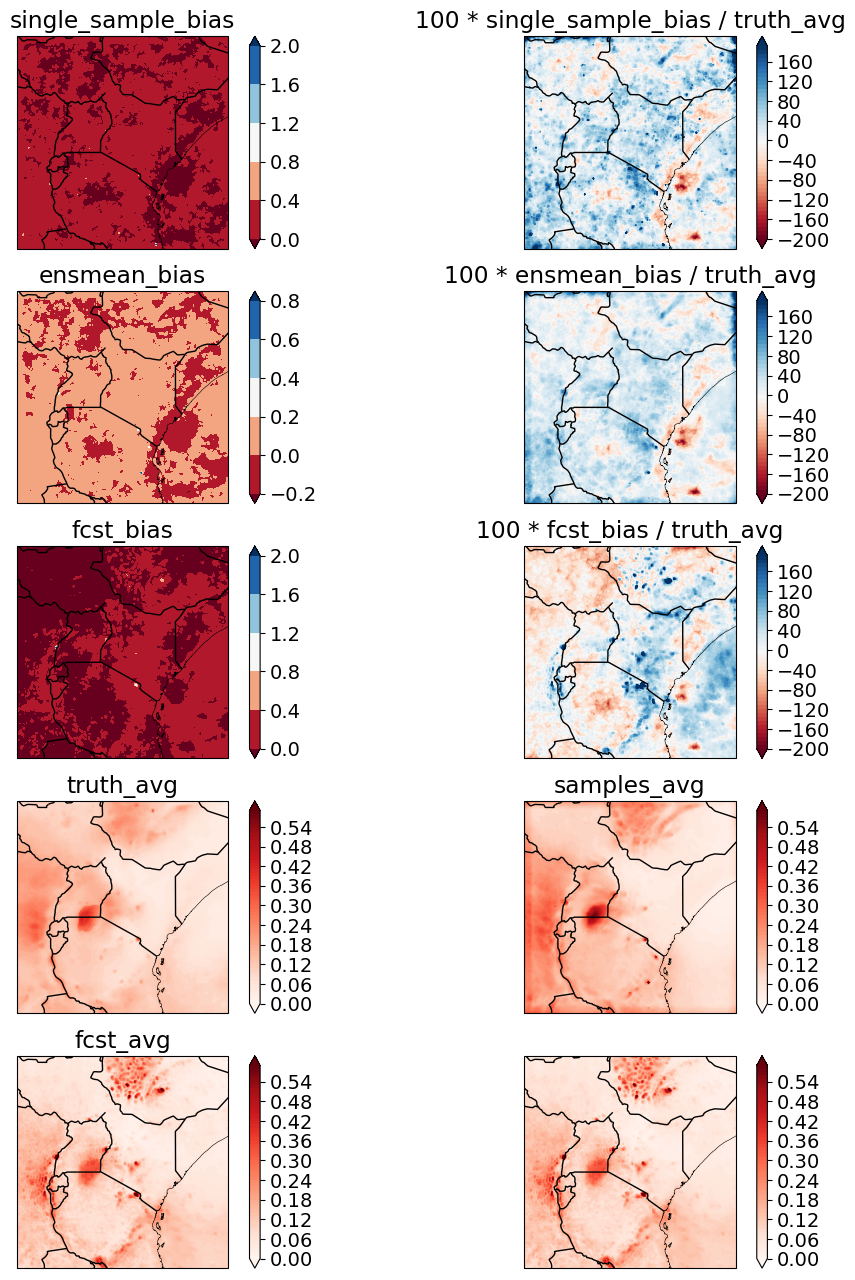

In [ ]:
lat_range=np.arange(-10.05, 10.05, 0.1)
lon_range=np.arange(25.05, 45.05, 0.1)
fig, ax = plt.subplots(len(bias_dict.keys())+2,2, 
                       subplot_kw={'projection' : ccrs.PlateCarree()},
                       figsize=(12,16))

max_bias_val = max([v.max() for v in bias_dict.values()])

for n, (k,v) in enumerate(bias_dict.items()):


    # value_range = list(np.arange(-0.5, 0.5, 0.01))
    value_range = None

    im = plot_contourf(ax[n,0], v, title=k, cmap='RdBu', value_range=value_range, lat_range=latitude_range, lon_range=longitude_range)
    plt.colorbar(im, ax=ax[n,0])
    
    im = plot_contourf(ax[n,1], 100* v / hourly_historical_avg, title=f'100 * {k} / truth_avg', value_range=list(np.arange(-200, 200, 400 / 50)),
                       cmap='RdBu', lat_range=latitude_range, lon_range=longitude_range)
    plt.colorbar(im, ax=ax[n,1])
    
im = plot_contourf(ax[n+1,0], hourly_historical_avg, title='truth_avg', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)), lat_range=latitude_range, lon_range=longitude_range)
plt.colorbar(im, ax=ax[n+1,0])

im = plot_contourf(ax[n+1,1], np.mean(np.mean(samples_gen_array, axis=-1), axis=0), title='samples_avg', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)), lat_range=latitude_range, lon_range=longitude_range)
plt.colorbar(im, ax=ax[n+1,1])

im = plot_contourf(ax[n+2,0], np.mean(fcst_array, axis=0), title='fcst_avg', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)), lat_range=latitude_range, lon_range=longitude_range)
plt.colorbar(im, ax=ax[n+2,0])

im = plot_contourf(ax[n+2,1], np.mean(fcst_array, axis=0), title='', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)), lat_range=latitude_range, lon_range=longitude_range)
plt.colorbar(im, ax=ax[n+2,1])

plt.savefig('cgan_metrics/bias.png')


## CRPS

In [ ]:
from properscoring import crps_ensemble

# crps_ensemble expects truth dims [N, H, W], pred dims [N, H, W, C]
crps_score_grid = crps_ensemble(truth_array, samples_gen_array)
crps_score = crps_score_grid.mean()

TypeError: Length of x (265) must match number of columns in z (200)

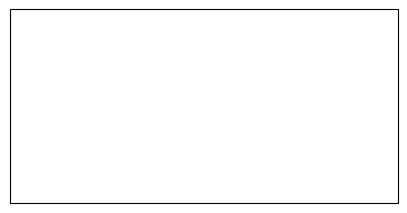

In [ ]:
fig, ax = plt.subplots(1, 1, 
                       subplot_kw={'projection' : ccrs.PlateCarree()}, figsize=(5,5))


max_level = 10
value_range = list(np.arange(0, max_level, max_level / 50))

im = ax.contourf(longitude_range, DEFAULT_LATITUDE_RANGE, np.mean(crps_score_grid, axis=0), transform=ccrs.PlateCarree(),
                    cmap='Reds', 
                    # levels=value_range, norm=colors.Normalize(min(value_range), max(value_range)),
                    extend='both')

ax.coastlines(resolution='10m', color='black', linewidth=0.4)
ax.add_feature(cfeature.BORDERS)
plt.colorbar(im, ax=ax)
plt.savefig('cgan_metrics/crps.png')


## Scatter plots

In [ ]:
import random

truth = arrays['truth']
samples_gen = arrays['samples_gen']

(num_images, height, width, ensemble_size) = samples_gen.shape

stacked_truth = np.repeat(truth[:, :, :, np.newaxis], ensemble_size, axis=3)

In [ ]:
indexes = random.sample(range(len(samples_gen.flatten())), 10000)

KeyboardInterrupt: 

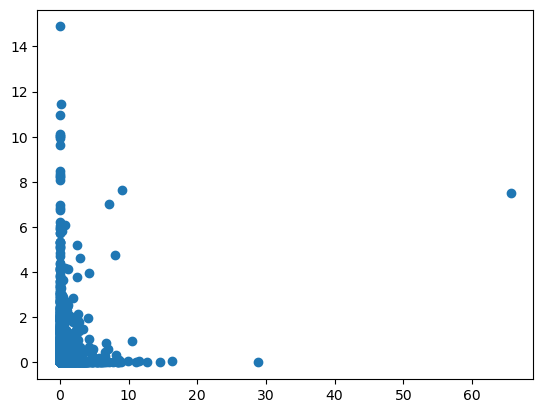

In [ ]:
plt.scatter(samples_gen.flatten()[indexes], stacked_truth.flatten()[indexes])

# Fractional skill score

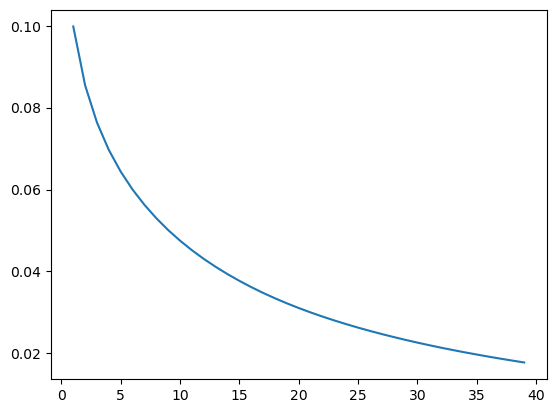

In [ ]:
#evaluate percentage of rainy pixels based on threshold
daily_thresholds = range(1,40)
num_rainy_pixels = []
for thr in daily_thresholds:
    num_rainy_pixels.append((truth_array >= thr/24.0).astype(np.single).mean())
plt.plot(daily_thresholds, num_rainy_pixels)

In [ ]:
from dsrnngan.scoring import fss
from tqdm import tqdm


window_sizes = list(range(1,11)) + [20, 40, 60, 80, 100] + [150, 200]
daily_thresholds = [1, 5, 20, 30, 50] # 1mm/day = drizzle, 50 mm/day = extreme

fss_cgan = []
fss_fcst = []
fss_ensmean = []

for thr in daily_thresholds:

    tmp_fss_cgan = []
    tmp_fss_fcst = []
    tmp_fss_ensmean = []

    for w in tqdm(window_sizes):
        
        tmp_fss_cgan.append(fss(truth_array, samples_gen_array, w, thr/24.0, mode='constant'))
        tmp_fss_fcst.append(fss(truth_array, fcst_array, w, thr/24.0, mode='constant'))
        tmp_fss_ensmean.append(fss(truth_array, ensmean_array, w, thr/24.0, mode='constant'))
    
    fss_cgan.append(tmp_fss_cgan)
    fss_fcst.append(tmp_fss_fcst)
    fss_ensmean.append(tmp_fss_ensmean)

100%|██████████| 17/17 [05:39<00:00, 19.98s/it]


NameError: name 'daily_thresholds' is not defined

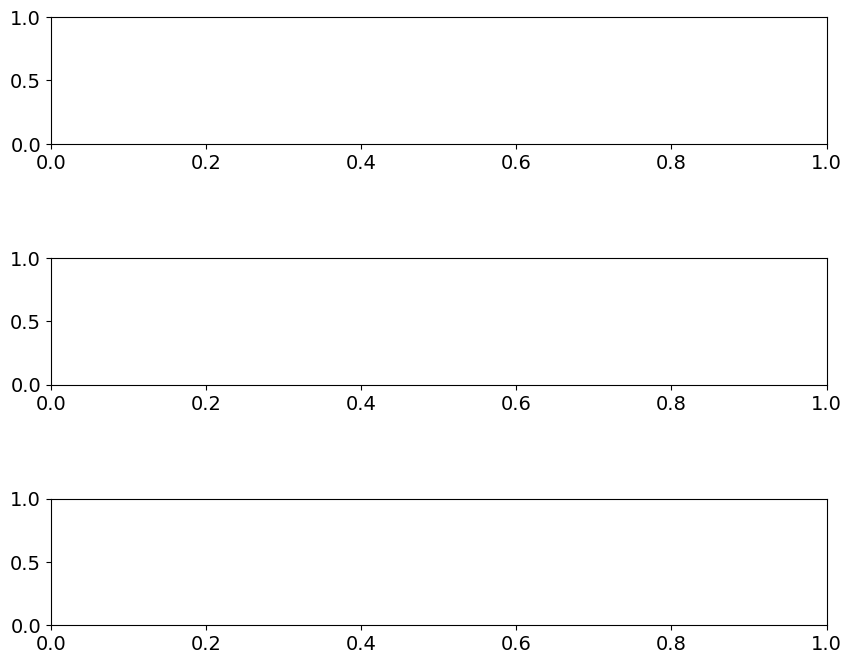

In [ ]:
fig, axs = plt.subplots(3, 1, figsize = (10, 8))
fig.tight_layout(pad=4.0)
linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (0, (1,10))]

for n, thr in enumerate(daily_thresholds):
    
    axs[0].plot(window_sizes, [item for item in fss_cgan[n]], label=f'{thr} mm/day', color='b', linestyle=linestyles[n])
    # axs[1].plot(window_sizes, [item for item in fss_ensmean[n]], label=f'{thr} mm/day', color='b', linestyle=linestyles[n])
    axs[1].plot(window_sizes, [item for item in fss_fcst[n]], label=f'{thr} mm/day', color='b', linestyle=linestyles[n])

    axs[0].set_title('cGAN sample')
    # axs[1].set_title('Ensemble mean')
    axs[1].set_title('IFS fcst')

for ax in axs:    
    ax.hlines(0.5, 0, max(window_sizes), linestyles='dashed', colors=['r'])
    ax.set_ylim(0,1)
    ax.set_xlabel('Neighbourhood size')
    ax.set_ylabel('FSS')
    ax.legend()
    
plt.savefig('cgan_metrics/fractional_skill_score.png')

# Plot to compare cgan and IFS directly


## Diurnal cycle

In [ ]:
from timezonefinder import TimezoneFinder
from dateutil import tz
from datetime import datetime

tf = TimezoneFinder()
from_zone = tz.gettz('UTC')

In [ ]:
hourly_data_obs = {}
hourly_data_sample = {}
hourly_data_fcst = {}
hourly_counts = {}

from_zone = tz.gettz('UTC')


for n in tqdm(range(n_samples)):
    obs = truth_array[n,:,:]
    sample = samples_gen_array[n,:,:,0]
    fcst = fcst_array[n, :, :]
    h = hours[n][0]
    d = dates[n][0]
    
    utc_datetime = datetime(d.year, d.month, d.day, h)
    utc_datetime.replace(tzinfo=from_zone)
    
    for long in longitude_range:
        
        timezone = tf.timezone_at(lng=long, lat=np.mean(latitude_range))
        to_zone = tz.gettz(timezone)
        
        local_hour = utc_datetime.astimezone(to_zone)
        
        if local_hour not in hourly_data_obs:
            hourly_data_obs[local_hour] = obs.sum()
            hourly_data_sample[local_hour] = sample.sum()
            hourly_data_fcst[local_hour] = fcst.sum()
            hourly_counts[local_hour] = 1
        else:
            hourly_data_obs[local_hour] += obs.sum()
            hourly_data_sample[local_hour] += sample.sum()
            hourly_data_fcst[local_hour] += fcst.sum()
            hourly_counts[local_hour] += 1
        

100%|██████████| 1000/1000 [01:24<00:00, 11.77it/s]


In [ ]:
diurnal_data_dict

NameError: name 'diurnal_data_dict' is not defined

KeyError: 0

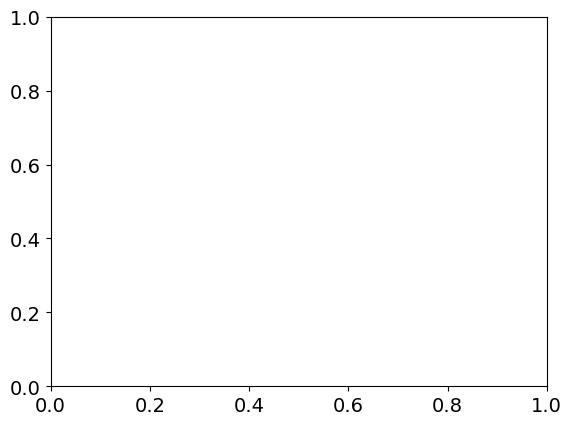

In [ ]:
# Plot diurnal cycle

fig, ax = plt.subplots(1,1)
diurnal_data_dict = {'IMERG': hourly_data_obs,
                     'cGAN sample': hourly_data_sample,
                     'IFS': hourly_data_fcst}

for name, data in diurnal_data_dict.items():
    
    mean_hourly_data = [np.mean(data[n] / hourly_counts[n]) for n in range(23)]
    
    ax.plot(mean_hourly_data, label=name)
    
ax.legend()
ax.set_xlabel('Hour')
ax.set_ylabel('Average mm/hr')  

Text(0, 0.5, 'Average mm/hr')

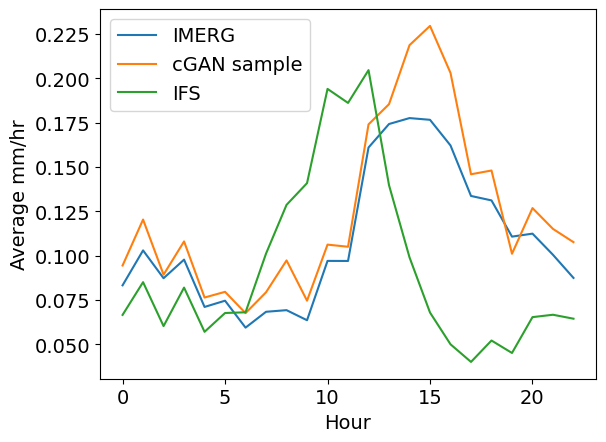

In [ ]:
# Plot diurnal cycle

fig, ax = plt.subplots(1,1)
diurnal_data_dict = {'IMERG': hourly_data_obs,
                     'cGAN sample': hourly_data_sample,
                     'IFS': hourly_data_fcst}

for name, data in diurnal_data_dict.items():
    
    mean_hourly_data = [np.mean(data[n] / hourly_counts[n]) for n in range(23)]
    
    ax.plot(mean_hourly_data, label=name)
    
ax.legend()
ax.set_xlabel('Hour')
ax.set_ylabel('Average mm/hr')      

100%|██████████| 1000/1000 [00:00<00:00, 66343.53it/s]


{20: 42, 16: 41, 6: 39, 17: 48, 9: 45, 14: 45, 19: 49, 0: 53, 11: 35, 22: 37, 4: 42, 2: 40, 18: 44, 1: 44, 13: 40, 15: 42, 5: 42, 12: 39, 10: 43, 7: 43, 3: 34, 23: 43, 8: 36, 21: 34}


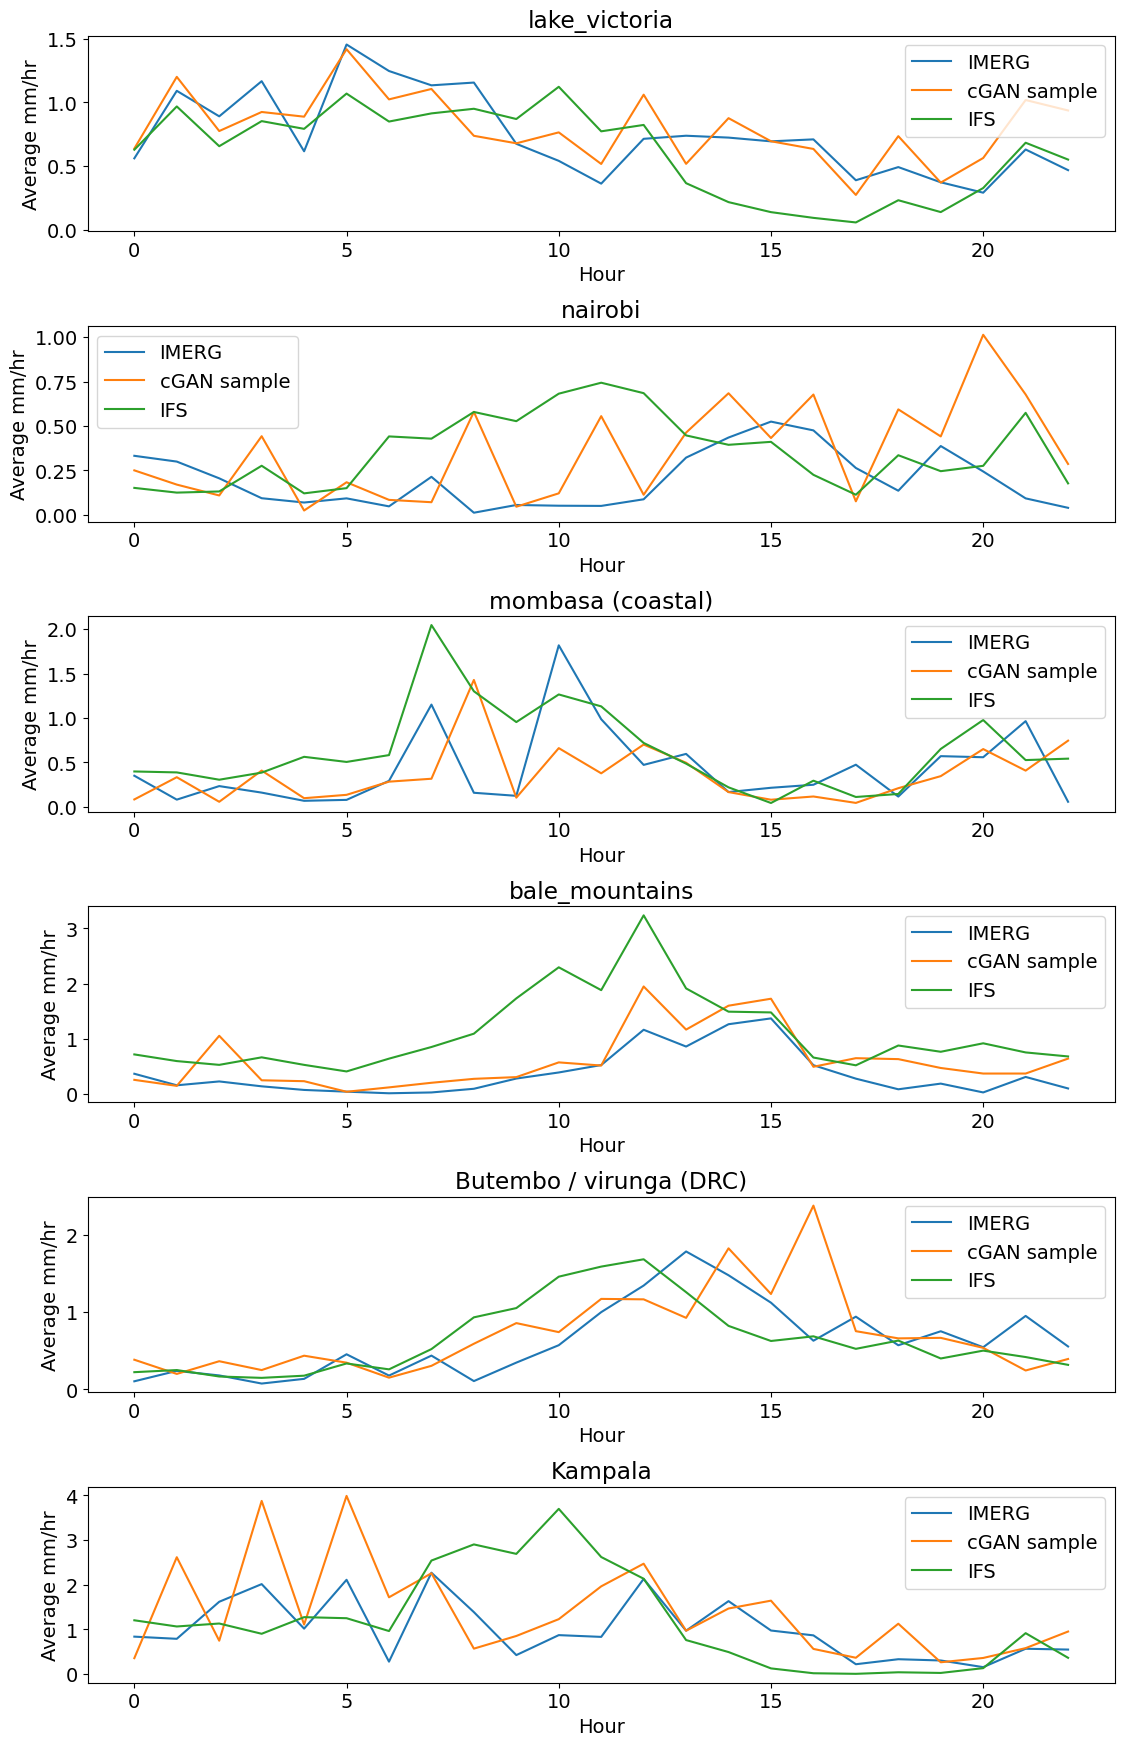

In [ ]:
# Diurnal cycles for different areas

hourly_area_data_obs = {}
hourly_area_data_sample = {}
hourly_area_data_fcst = {}
hourly_counts = {}
for n, (area, area_range) in enumerate(special_areas.items()):

    lat_range = area_range['lat_index_range']
    lon_range = area_range['lon_index_range']
    
    hourly_area_data_obs[area] = {}
    hourly_area_data_sample[area] = {}
    hourly_area_data_fcst[area] = {}
    hourly_counts = {}

    for n in tqdm(range(n_samples)):
        obs = truth_array[n, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]]
        sample = samples_gen_array[n, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1],0]
        fcst = fcst_array[n, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]]
        hour = hours[n][0]
        
        if hour not in hourly_area_data_obs[area]:
            hourly_area_data_obs[area][hour] = obs
            hourly_area_data_sample[area][hour] = sample
            hourly_area_data_fcst[area][hour] = fcst
            hourly_counts[hour] = 1
        else:
            hourly_area_data_obs[area][hour] += obs
            hourly_area_data_sample[area][hour] += sample
            hourly_area_data_fcst[area][hour] += fcst
            hourly_counts[hour] += 1
print(hourly_counts)

# Plot diurnal cycle for the different areas

fig, ax = plt.subplots(len(special_areas),1, figsize=(12,18))
fig.tight_layout(pad=3)
diurnal_data_dict = {'IMERG': hourly_area_data_obs,
                     'cGAN sample': hourly_area_data_sample,
                     'IFS': hourly_area_data_fcst}
# TODO: get errorbars on this
for n, area in enumerate(special_areas):
    for name, data in diurnal_data_dict.items():
        grid_average = [data[area][n] / hourly_counts[n] for n in range(23)]
        mean_hourly_data = [np.mean(data[area][n] / hourly_counts[n]) for n in range(23)]
        
        ax[n].plot(mean_hourly_data, label=name)
    
    ax[n].legend()
    ax[n].set_xlabel('Hour')
    ax[n].set_ylabel('Average mm/hr')
    ax[n].set_title(area)

100%|██████████| 1000/1000 [00:00<00:00, 5303.45it/s]


{16: 12, 6: 10, 14: 10, 22: 11, 13: 12, 15: 8, 12: 12, 0: 12, 4: 9, 18: 11, 1: 8, 19: 15, 23: 12, 8: 9, 9: 11, 10: 12, 7: 11, 17: 9, 3: 6, 11: 8, 21: 12, 2: 8, 5: 7, 20: 7}


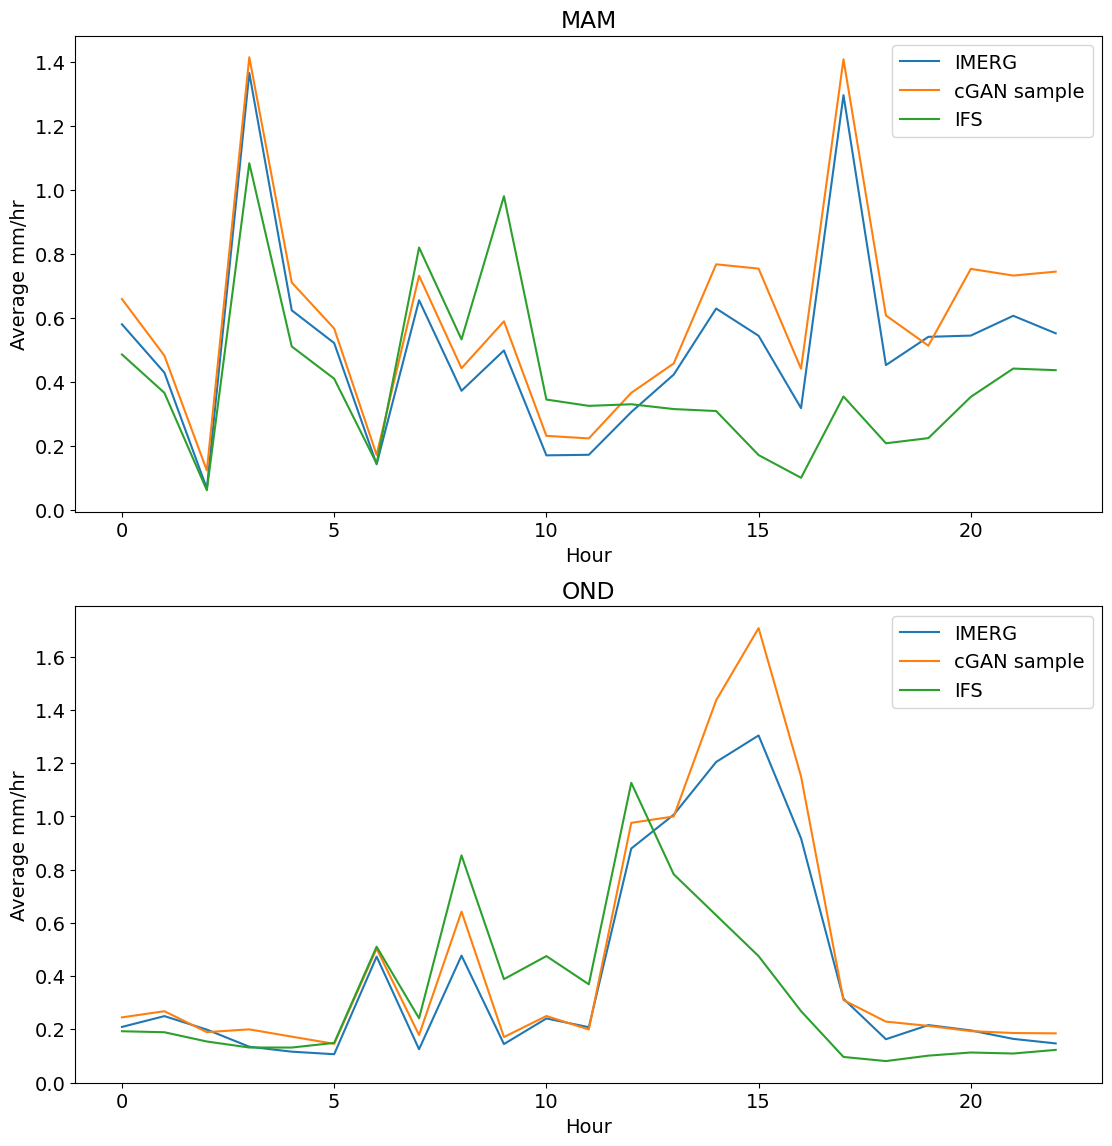

In [ ]:
# Diurnal cycle for different seasons

from collections import Counter

seasons_dict = {'MAM': [3,4,5], 'OND': [10,11,12]}

hourly_season_data_obs = {}
hourly_season_data_sample = {}
hourly_season_data_fcst = {}
hourly_counts = {}
for n, (season, month_range) in enumerate(seasons_dict.items()):
    
    hourly_season_data_obs[season] = {}
    hourly_season_data_sample[season] = {}
    hourly_season_data_fcst[season] = {}
    hourly_counts = {}

    for n in tqdm(range(n_samples)):
        obs = truth_array[n, :, :]
        sample = samples_gen_array[n, :,:,0]
        fcst = fcst_array[n, :,:]
        hour = hours[n][0]
        date = dates[n][0]
        
        if date.month in month_range:
            if hour not in hourly_season_data_obs[season]:
                hourly_season_data_obs[season][hour] = obs
                hourly_season_data_sample[season][hour] = sample
                hourly_season_data_fcst[season][hour] = fcst
                hourly_counts[hour] = 1
            else:
                hourly_season_data_obs[season][hour] += obs
                hourly_season_data_sample[season][hour] += sample
                hourly_season_data_fcst[season][hour] += fcst
                hourly_counts[hour] += 1

# Plot diurnal cycle for the different areas

fig, ax = plt.subplots(len(seasons_dict),1, figsize=(12,12))
fig.tight_layout(pad=3)
diurnal_data_dict = {'IMERG': hourly_season_data_obs,
                     'cGAN sample': hourly_season_data_sample,
                     'IFS': hourly_season_data_fcst}
print(hourly_counts)
for n, season in enumerate(seasons_dict):
    for name, data in diurnal_data_dict.items():
        
        mean_hourly_data = [np.mean(data[season][n] / hourly_counts[n]) for n in range(23)]
        
        ax[n].plot(mean_hourly_data, label=name)
    
    ax[n].legend()
    ax[n].set_xlabel('Hour')
    ax[n].set_ylabel('Average mm/hr')
    ax[n].set_title(season)

## Check locations of maximum rainfall

In [ ]:
max_samples_gen = np.max(np.max(samples_gen_array, axis=-1), axis=0)
max_truth = np.max(truth_array, axis=0)

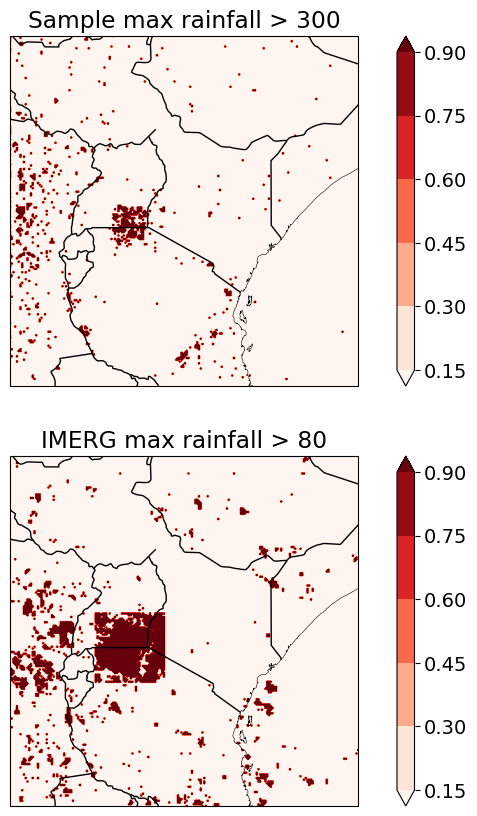

In [ ]:
fig, ax = plt.subplots(2,1, subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(10,10))
threshold = 300
im = plot_contourf(ax[0], (max_samples_gen > threshold), title=f'Sample max rainfall > {threshold}', cmap='Reds', lat_range=DEFAULT_LATITUDE_RANGE, 
                   lon_range=DEFAULT_LONGITUDE_RANGE)
plt.colorbar(im, ax=ax[0])

obs_thresold = 80
im = plot_contourf(ax[1], (max_truth > obs_thresold), title=f'IMERG max rainfall > {obs_thresold}', cmap='Reds', lat_range=DEFAULT_LATITUDE_RANGE, 
                   lon_range=longitude_range)
plt.colorbar(im, ax=ax[1])

## Single pixel time series


In [ ]:

log_folder_consecutive = '/user/work/uz22147/logs/cgan/d9b8e8059631e76f/n1000_201810-201812_e50'

with open(os.path.join(log_folder_consecutive, f'arrays-160000.pkl'), 'rb') as ifh:
    consecutive_arrays = pickle.load(ifh)
    
cons_truth_array = consecutive_arrays['truth']
cons_samples_gen_array = consecutive_arrays['samples_gen']
cons_fcst_array = consecutive_arrays['fcst_array']
cons_ensmean_array = np.mean(consecutive_arrays['samples_gen'], axis=-1)
cons_dates = consecutive_arrays['dates']
cons_hours = consecutive_arrays['hours']


## Check training data for high rainfall

In [ ]:
# Check range of values in training data
from dsrnngan.tfrecords_generator import create_mixed_dataset, DataGenerator

train = DataGenerator('train',
                           batch_size=1,
                           fcst_shape=(200, 200, 20),
                            con_shape=(200, 200, 2),
                            out_shape=(200, 200, 1),
                           downsample=False, 
                           weights=[0.4, 0.3, 0.2, 0.1], 
                           records_folder='/user/work/uz22147/tfrecords/d34d309eb0e00b04', 
                           )



2023-02-03 14:09:19.309283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/user/work/uz22147/miniconda3/lib/
2023-02-03 14:09:19.309392: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-03 14:09:19.309440: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bp1-login01.data.bp.acrc.priv): /proc/driver/nvidia/version does not exist
2023-02-03 14:09:19.310941: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
from tqdm import tqdm
from dsrnngan.data import denormalise

max_rainfall = 0
take_n = 20000

for a in tqdm(train.take(take_n).as_numpy_iterator()):
    ifs_input = a[0]['lo_res_inputs']
    imerg_output = a[1]['output']
    
    if denormalise(imerg_output.max()) > max_rainfall:
        max_rainfall = denormalise(imerg_output.max())

20000it [00:35, 555.92it/s]


In [ ]:
max_rainfall

105.64359813259901

## Quantiles with training time

In [ ]:
from sklearn.linear_model import LinearRegression

model_numbers = sorted([153600,147200,140800,134400,128000,121600,115200,108800])

truth_quantiles = {}
sample_quantiles = {}

for model_number in tqdm(model_numbers, total=len(model_numbers)):
    if model_number == 160000:
        log_folder = '/user/work/uz22147/logs/cgan/38fba564f1c9852b/n1000_201806-201905_e50'
    else:
        log_folder = '/user/work/uz22147/logs/cgan/d9b8e8059631e76f/n1000_201806-201905_e50'

    with open(os.path.join(log_folder, f'arrays-{model_number}.pkl'), 'rb') as ifh:
        arrays = pickle.load(ifh)
        
    truth_array = arrays['truth']
    samples_gen_array = arrays['samples_gen']
    fcst_array = arrays['fcst_array']
    ensmean_array = np.mean(arrays['samples_gen'], axis=-1)
    dates = arrays['dates']
    hours = arrays['hours']

    (n_samples, width, height, ensemble_size) = samples_gen_array.shape

    ## This is needed until code is fixed

    if model_number == 160000:
        for n in range(fcst_array.shape[0]):
            fcst_array[n,:,:] = denormalise(fcst_array[n,:,:])
            
    number_in_top_range = 10000
    quantile_boundaries = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8] + list(np.linspace(0.9, 1.0, number_in_top_range))
    truth_quantiles[model_number] = np.quantile(truth_array, quantile_boundaries)
    sample_quantiles[model_number] = np.quantile(samples_gen_array[:,:,:,0], quantile_boundaries)
    print('Number data points per quantile in top range: ', 0.1*len(truth_array.flatten()) / number_in_top_range)
    print('percentile steps in top range: ', 10 / number_in_top_range)
    
fig, ax = plt.subplots(1,1, figsize=(8,6))

for n, model_number in enumerate(model_numbers):
    
    truth_q = truth_quantiles[model_number]
    sample_q = sample_quantiles[model_number]
    
    ax.plot(truth_q, sample_q, label=model_number)

ax.legend()
plt.savefig('cgan_metrics/quantiles_by_iterations.png')

In [ ]:
!zip -r cgan_metrics.zip cgan_metrics

updating: cgan_metrics/ (stored 0%)
updating: cgan_metrics/fractional_skill_score.png (deflated 8%)
updating: cgan_metrics/bias.png (deflated 2%)
updating: cgan_metrics/quantiles_total.png (deflated 15%)
updating: cgan_metrics/rank_hist.png (deflated 16%)
updating: cgan_metrics/quantiles_area.png (deflated 21%)
updating: cgan_metrics/rmse.png (deflated 2%)
updating: cgan_metrics/rapds.png (deflated 6%)
updating: cgan_metrics/crps.png (deflated 10%)
  adding: cgan_metrics/cGAN_samples_IFS.png (deflated 6%)
